In [1]:
import re
import numpy as np
import pandas as pd
import pickle
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# 사용 모델
from sklearn.ensemble import RandomForestClassifier
import lib.EncoderModel as mm

# 함수들 불러오기
import lib.functions as f

# 평가에 이용되는 함수 정의

In [2]:
# 1차 filter용 데이터셋 정의 -> (조문 + 조문제목) [embedding vector화 + 배치화]
class CustomDataset1(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # '조문'과 '법령명' 칼럼의 데이터를 안전하게 문자열로 변환하고 결합
        text1 = str(self.data.iloc[idx]['조문'])
        text2 = str(self.data.iloc[idx]['조문제목'])
        text_data = text1 + " // " + text2
        label = torch.tensor(self.data.iloc[idx]['사무판단'], dtype=torch.long)

        # 결합된 텍스트를 토크나이징
        tokenized_data = tokenizer([text_data], padding='max_length', max_length=512, truncation=True, return_tensors='pt')

        return {
            'input_ids': tokenized_data['input_ids'].squeeze(),
            'attention_mask': tokenized_data['attention_mask'].squeeze(),
            'labels': label
        }

In [3]:
# 2차 filter용 데이터셋 정의 -> (법령명 + 조문제목 + 수행주체) [embedding vector화 + 배치화]
class CustomDataset2(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # '조문'과 '법령명' 칼럼의 데이터를 안전하게 문자열로 변환하고 결합
        text1 = str(self.data.iloc[idx]['법령명'])
        text2 = str(self.data.iloc[idx]['조문제목'])
        text3 = str(self.data.iloc[idx]['수행주체(문자열)'])
        text_data = text1 + " // " + text2 + " // " + text3
        label = torch.tensor(self.data.iloc[idx]['사무유형(대분류)'], dtype=torch.long)

        # 결합된 텍스트를 토크나이징
        tokenized_data = tokenizer([text_data], padding='max_length', max_length=128, truncation=True, return_tensors='pt')

        return {
            'input_ids': tokenized_data['input_ids'].squeeze(),
            'attention_mask': tokenized_data['attention_mask'].squeeze(),
            'labels': label
        }

In [4]:
# 각 배치의 텍스트 길이를 맞추기
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # 패딩 적용
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': torch.stack(labels)}


In [5]:
# 평가 결과 확인
def cal_result(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    # 결과 출력
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)

In [6]:
def cal_result2(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    print('혼동행렬')
    print(conf_matrix)
    accuracy = accuracy_score(y, preds)
    print(f'정확도: {accuracy}')
    class_report = classification_report(y, preds)
    print('Classification Report:')
    print(class_report)
    
    return conf_matrix

# 1. 데이터 입력

In [7]:
test_df = pd.read_csv('data/FinalBaseTable.csv')
test_df.info()

/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_63165/1265917946.py:1: DtypeWarning: Columns (4,5,18,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('data/FinalBaseTable.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848072 entries, 0 to 848071
Data columns (total 26 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   소관부처명      848072 non-null  object
 1   법령명        848072 non-null  object
 2   법령구분       848072 non-null  int64 
 3   조번호        847493 non-null  object
 4   항번호        655168 non-null  object
 5   호번호        498265 non-null  object
 6   조문제목       848072 non-null  object
 7   조문         848072 non-null  object
 8   사무판단       848072 non-null  int64 
 9   사무판단근거     687920 non-null  object
 10  사무명        54588 non-null   object
 11  수행주체       54590 non-null   object
 12  사무유형       54546 non-null   object
 13  위임사무판단     848072 non-null  int64 
 14  위임근거규정     3749 non-null    object
 15  수임기관       2899 non-null    object
 16  특행기관       848072 non-null  int64 
 17  재위임사무판단    848072 non-null  int64 
 18  재위임근거규정    3 non-null       object
 19  재수임기관      2 non-null       object
 20  위탁사무

In [72]:
# 전처리 단계에서의 총 조문개수, 사무 개수 저장
t1 = len(test_df)
s1 = len(test_df.loc[test_df['사무판단']==1, :])

# 2. 데이터 전처리

In [11]:
#test_df = f.x_null_drop(test_df)
#test_df = f.x_wrong_drop(test_df)
test_df = f.no_work_check(test_df)
test_df = f.make_large_type(test_df)

In [12]:
# 결과 저장 데이터 프레임 생성
check_cols = ['법령명' ,'조문제목', '조문', '사무판단', '사무유형(대분류)']
sub_df = test_df.loc[:, check_cols].copy()
sub_df.shape

(848072, 5)

# 3. Rule-Base 적용

In [17]:
sub_df = f.rule_based(sub_df)  # rule_base 조문 확인

# rule_base로 걸러낸 조문들
rule_base_filter_idx = sub_df.loc[sub_df['rule_based']==0, :].index

In [18]:
sub_df

,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based
0,개인정보 보호법,0,제1장 총칙,0,0,0
1,개인정보 보호법,목적,제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자...,0,0,0
2,개인정보 보호법,정의,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2014.3.2...,0,0,0
3,개인정보 보호법,정의,"1. ""개인정보""란 살아 있는 개인에 관한 정보로서 다음 각 목의 어느 하나에 해당...",0,0,0
4,개인정보 보호법,정의,"1의2. ""가명처리""란 개인정보의 일부를 삭제하거나 일부 또는 전부를 대체하는 등의...",0,0,0
...,...,...,...,...,...,...
848067,수도법 시행규칙,기술진단 결과의 평가,1. 한국수자원공사,0,0,1
848068,수도법 시행규칙,기술진단 결과의 평가,2. 법 제56조에 따른 한국상하수도협회,0,0,1
848069,수도법 시행규칙,규제의 재검토,제32조(규제의 재검토) 환경부장관은 다음 각 호의 사항에 대하여 다음 각 호의 기...,0,0,1
848070,수도법 시행규칙,규제의 재검토,1. 제23조의2제1항ㆍ제4항 및 별표 7의2에 따른 저수조청소업의 인력ㆍ시설 및 ...,0,0,1


In [73]:
ex = sub_df.loc[(sub_df['rule_based']!=0), :]
t2 = len(ex)
s2 = len(ex.loc[ex['사무판단']==1, :])

In [45]:
ex

,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based
13,개인정보 보호법,개인정보 보호 원칙,① 개인정보처리자는 개인정보의 처리 목적을 명확하게 하여야 하고 그 목적에 필요한 ...,0,0,1
14,개인정보 보호법,개인정보 보호 원칙,② 개인정보처리자는 개인정보의 처리 목적에 필요한 범위에서 적합하게 개인정보를 처리...,0,0,1
15,개인정보 보호법,개인정보 보호 원칙,"③ 개인정보처리자는 개인정보의 처리 목적에 필요한 범위에서 개인정보의 정확성, 완전...",0,0,1
16,개인정보 보호법,개인정보 보호 원칙,④ 개인정보처리자는 개인정보의 처리 방법 및 종류 등에 따라 정보주체의 권리가 침해...,0,0,1
17,개인정보 보호법,개인정보 보호 원칙,⑤ 개인정보처리자는 개인정보 처리방침 등 개인정보의 처리에 관한 사항을 공개하여야 ...,0,0,1
...,...,...,...,...,...,...
848067,수도법 시행규칙,기술진단 결과의 평가,1. 한국수자원공사,0,0,1
848068,수도법 시행규칙,기술진단 결과의 평가,2. 법 제56조에 따른 한국상하수도협회,0,0,1
848069,수도법 시행규칙,규제의 재검토,제32조(규제의 재검토) 환경부장관은 다음 각 호의 사항에 대하여 다음 각 호의 기...,0,0,1
848070,수도법 시행규칙,규제의 재검토,1. 제23조의2제1항ㆍ제4항 및 별표 7의2에 따른 저수조청소업의 인력ㆍ시설 및 ...,0,0,1


# 4. 1차 사무판단
## encoder 모델

* encoder 구조 생성

In [39]:
# 모델 및 토크나이저 불러오기
model_name = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 모델 기본 구조 설정
input_size = 512
hidden_size = 256
output_size = 2
num_encoder_layers = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mm.MyModel(input_size, hidden_size, output_size, num_encoder_layers)
model.to(device)

MyModel(
  (encoder): MyEncoder(
    (layers): ModuleList(
      (0): MyEncoderLayer(
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer1): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer2): Linear(in_features=256, out_features=2, bias=True)
)

* 학습된 encoder 불러오기

In [40]:
model_path = 'pickles/encoder_model_f1_all.pth'  # Provide the correct path
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

* 모델 평가

In [41]:
# 데이터로더 생성
batch_size = 16  # 배치크기 조절

test_dataset = CustomDataset1(ex, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [42]:
model.eval()

test_loss = 0
probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc=f'Validation'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        outputs = model(**inputs).float()
        test_loss += torch.nn.functional.cross_entropy(outputs, labels.long())
        
        # 소프트맥스를 적용하여 확률값 얻기
        probs_batch = torch.nn.functional.softmax(outputs, dim=1)
        probs.append(probs_batch.cpu().numpy())

# 손실 계산
avg_test_loss = test_loss / len(test_loader)

# 확률값을 하나의 배열로 통합
probs = np.concatenate(probs, axis=0)

print(avg_test_loss)

Validation: 100%|████████████████████████| 43008/43008 [03:38<00:00, 197.07it/s]


tensor(0.4287)


In [74]:
# 결과 확률 저장
prob_1 = probs[:, 1]
prob_1 = [round(prob, 5) for prob in prob_1]

In [75]:
sub_df.head(1)

,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based
0,개인정보 보호법,0,제1장 총칙,0,0,0


## 1차 사무판단 진행

In [76]:
threshold = 0.251    # test 결과로 확인한 threshold

ex['사무판단 예측'] = 0
ex['사무판단 예측확률'] = prob_1

# 1차 사무판단
ex.loc[ex['사무판단 예측확률'] >= threshold, '사무판단 예측'] = 1

/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_63165/773814121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['사무판단 예측'] = 0
/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_63165/773814121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['사무판단 예측확률'] = prob_1


In [77]:
ex

,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무판단 예측,사무판단 예측확률
13,개인정보 보호법,개인정보 보호 원칙,① 개인정보처리자는 개인정보의 처리 목적을 명확하게 하여야 하고 그 목적에 필요한 ...,0,0,1,1,0.72994
14,개인정보 보호법,개인정보 보호 원칙,② 개인정보처리자는 개인정보의 처리 목적에 필요한 범위에서 적합하게 개인정보를 처리...,0,0,1,1,0.77519
15,개인정보 보호법,개인정보 보호 원칙,"③ 개인정보처리자는 개인정보의 처리 목적에 필요한 범위에서 개인정보의 정확성, 완전...",0,0,1,1,0.67727
16,개인정보 보호법,개인정보 보호 원칙,④ 개인정보처리자는 개인정보의 처리 방법 및 종류 등에 따라 정보주체의 권리가 침해...,0,0,1,1,0.62545
17,개인정보 보호법,개인정보 보호 원칙,⑤ 개인정보처리자는 개인정보 처리방침 등 개인정보의 처리에 관한 사항을 공개하여야 ...,0,0,1,1,0.72825
...,...,...,...,...,...,...,...,...
848067,수도법 시행규칙,기술진단 결과의 평가,1. 한국수자원공사,0,0,1,0,0.00549
848068,수도법 시행규칙,기술진단 결과의 평가,2. 법 제56조에 따른 한국상하수도협회,0,0,1,0,0.00258
848069,수도법 시행규칙,규제의 재검토,제32조(규제의 재검토) 환경부장관은 다음 각 호의 사항에 대하여 다음 각 호의 기...,0,0,1,1,0.64245
848070,수도법 시행규칙,규제의 재검토,1. 제23조의2제1항ㆍ제4항 및 별표 7의2에 따른 저수조청소업의 인력ㆍ시설 및 ...,0,0,1,0,0.03126


In [25]:
#sub_df.loc[(sub_df['사무예측 결과']==0)&(sub_df['사무판단']!=0), :]    # 모델 예측 결과 틀린 부분

In [96]:
t3 = len(ex.loc[ex['사무판단 예측']==1, :])
s3 = len(ex.loc[(ex['사무판단 예측']==1)&(ex['사무판단']==1), '사무판단'])

ts = [t1, t2, t3]
ss = [s1, s2, s3]

print(ts)
print(ss)

t3/t1*100

[848072, 688125, 321249]
[54546, 54532, 52014]


37.87992057278156

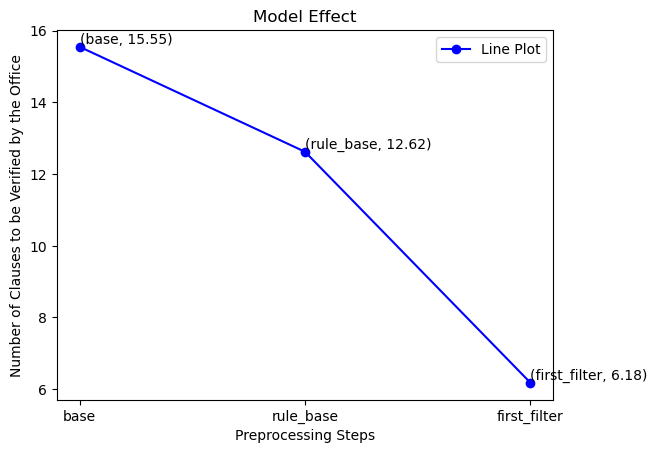

In [82]:
import matplotlib.pyplot as plt

final = []
for i in range(3):
    final.append(ts[i]/ss[i])

x_labels = ['base', 'rule_base', 'first_filter']

# 선 그래프 그리기
plt.plot(x_labels, final, marker='o', linestyle='-', color='b', label='Line Plot')

# 그래프에 레이블 추가
plt.title('Model Effect')
plt.xlabel('Preprocessing Steps')
plt.ylabel('Number of Clauses to be Verified by the Office')
plt.legend()

# 각 데이터 포인트의 좌표를 표시
for i, (x, y, ratio) in enumerate(zip(x_labels, final, ratios)):
    plt.text(x, y, f'({x}, {y:.2f})', ha='left', va='bottom')

# 그래프 출력
plt.show()

In [48]:
# 1차 필터링 결과
cal_result(ex['사무판단 예측'], ex['사무판단'])

Accuracy: 0.6050819255222525
Precision: 0.16191178805225853
Recall: 0.9538252769016358
F1-Score: 0.27683145236188106
Confusion Matrix:
[[364358 269235]
 [  2518  52014]]


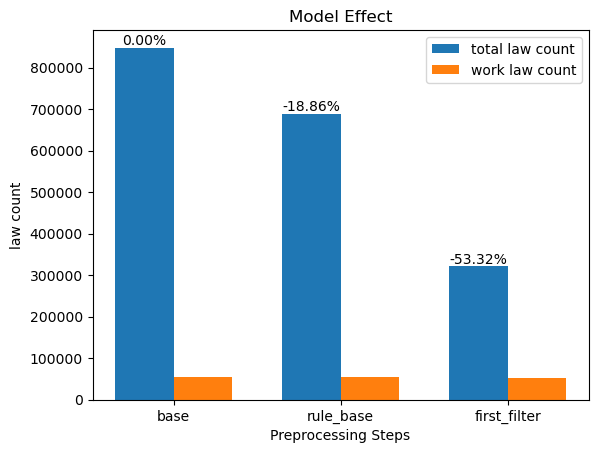

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 데이터
x_values = np.array([1, 2, 3])
x_labels = ['base', 'rule_base', 'first_filter']
ts = [848072, 688125, 321249]
ss = [54546, 54532, 52014]
decreases = [100 * ((t - t_prev) / t_prev) if i > 0 else 0 for i, (t, t_prev) in enumerate(zip(ts, [0] + ts[:-1]))]

# 막대 그래프 그리기
bar_width = 0.35  # 막대의 너비
bar_positions1 = x_values - bar_width/2
bar_positions2 = x_values + bar_width/2

fig, ax = plt.subplots()

bars1 = ax.bar(bar_positions1, ts, width=bar_width, label='total law count')
bars2 = ax.bar(bar_positions2, ss, width=bar_width, label='work law count')

# 그래프에 레이블 추가
plt.title('Model Effect')
plt.xlabel('Preprocessing Steps')
plt.ylabel('law count')
plt.legend()
plt.xticks(x_values, x_labels)  # X 축 레이블 설정

# 범례 추가
plt.legend()

# decrease 값을 막대 위에 표시
for bar, decrease in zip(bars1, decreases):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{decrease:.2f}%', ha='center', va='bottom')

# 그래프 표시
plt.show()


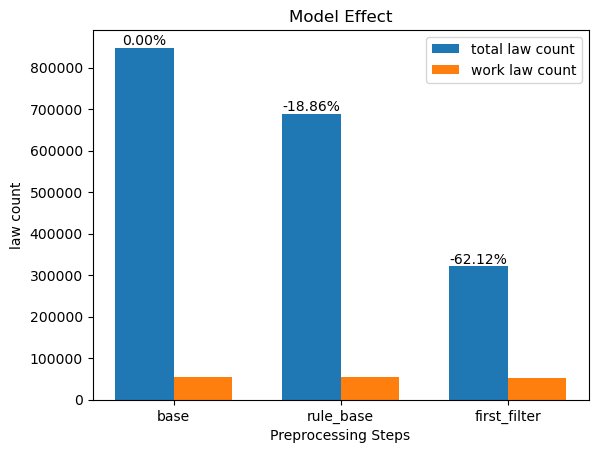

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 데이터
x_values = np.array([1, 2, 3])
x_labels = ['base', 'rule_base', 'first_filter']
ts = [848072, 688125, 321249]
ss = [54546, 54532, 52014]
decreases2 = [0, -18.86, -62.12]
# 막대 그래프 그리기
bar_width = 0.35  # 막대의 너비
bar_positions1 = x_values - bar_width/2
bar_positions2 = x_values + bar_width/2

fig, ax = plt.subplots()

bars1 = ax.bar(bar_positions1, ts, width=bar_width, label='total law count')
bars2 = ax.bar(bar_positions2, ss, width=bar_width, label='work law count')

# 그래프에 레이블 추가
plt.title('Model Effect')
plt.xlabel('Preprocessing Steps')
plt.ylabel('law count')
plt.legend()
plt.xticks(x_values, x_labels)  # X 축 레이블 설정

# 범례 추가
plt.legend()

# decrease 값을 막대 위에 표시
for bar, decrease in zip(bars1, decreases2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{decrease:.2f}%', ha='center', va='bottom')

# 그래프 표시
plt.show()
